# Basics of Object Detection

Jusqu'à présent, nous avons appris à effectuer une classification d'images. Imaginez un scénario dans lequel nous tirons parti de la vision par ordinateur pour une voiture autonome. Il est non seulement nécessaire de détecter si l'image d'une route contient les images de véhicules, d'un trottoir et de piétons, mais il est également important d'identifier où se trouvent ces objets. Diverses techniques de détection d'objets que nous étudierons dans cet article seront utiles dans un tel scénario.

Dans cet article et le suivant, nous allons découvrir quelques-unes des techniques de détection d'objets. Nous commencerons par en apprendre davantage sur les principes fondamentaux : extraire les propositions de région à l'aide de la méthode de recherche sélective et définir la précision des prédictions de la boîte englobante en utilisant la métrique Intersection overUnion (IoU) et la précision mean average. métrique. Après cela, nous découvrirons deux réseaux basés sur des propositions régionales - R-CNN et Fast R-CNN, en apprenant d'abord leurs détails de fonctionnement, puis en les implémentant sur un ensemble de données contenant des images appartenant à des camions et des bus.

## Introducing object detection

Avec l'essor des voitures autonomes, la détection faciale, la vidéosurveillance intelligente et des solutions de comptage de personnes, les systèmes de détection d'objets rapides sont très demandés. Ces systèmes incluent non seulement la classification des objets à partir d'une image, mais également la localisation de chacun des objets en dessinant des cadres de délimitation appropriés autour d'eux. Ceci (dessiner des cadres de délimitation et une classification) rend la détection d'objets plus difficile que son prédécesseur traditionnel de vision par ordinateur, la classification d'images.


Avant de comprendre les grands cas d'utilisation de la détection d'objets, comprenons comment cela s'ajoute à la tâche de classification d'objets.

Imaginez un scénario dans lequel vous avez plusieurs objets dans une image. Je vous demande de prédire la classe d'objets présents dans l'image. Par exemple, disons que l'image contient à la fois des chats et des chiens. Comment classeriez-vous de telles images ? La détection d'objets est utile dans un tel scénario, où elle prédit non seulement l'emplacement des objets (boîte de délimitation) qui y sont présents, mais prédit également la classe d'objets présents dans les boîtes de délimitation individuelles.

Certains des différents cas d'utilisation tirant parti de la détection d'objets incluent les suivants.

* **Sécurité** : Cela peut être utile pour reconnaître les intrus.
* **Voitures autonomes** : Cela peut être utile pour reconnaître les différents objets présents sur l'image d'une route.

* **Recherche d'images** : cela peut aider à identifier les images contenant un objet (ou une personne) d'intérêt.

* **Automobile** : cela peut aider à identifier une plaque d'immatriculation dans l'image d'une voiture.

Dans tous les cas précédents, la détection d'objets est utilisée pour dessiner des cadres de délimitation autour d'une variété d'objets présents dans l'image.


Nous allons apprendre à prédire la classe de l'objet et également à avoir un cadre de délimitation étroit autour de l'objet dans l'image, ce qui est la tâche de localisation. Nous apprendrons également à détecter la classe correspondant à plusieurs objets dans l'image, ainsi qu'un cadre de délimitation autour de chaque objet, qui est la tâche de détection d'objet.

La formation d'un modèle de détection d'objets typique implique les étapes suivantes:

* **1** Création de données de entrainement qui contiennent des étiquettes de la boîte englobante et  class correspondant à divers objets présents dans l'image

* **2** Concevoir des mécanismes qui parcourent l'image pour identifier les régions (propositions de régions) susceptibles de contenir des objets. Dans cet article , nous allons apprendre à tirer parti des propositions de régions générées par une méthode nommée recherche sélective. Dans le prochain article, nous apprendrons à tirer parti des boîtes d'ancrage pour identifier les régions contenant des objets. 

* **3** Création de la variable de classe cible à l'aide de la métrique IoU.

* **4** Création de la variable de décalage du cadre de délimitation cible pour apporter des corrections à l'emplacement de la proposition de région à venir dans la deuxième étape.

* **5** Construire un modèle qui peut prédire la classe d'objet avec le décalage de la zone de délimitation cible correspondant à la proposition de région

* **6** Mesure de la précision de la détection d'objets à l'aide de la précision moyenne moyenne (mAP


## Understanding region proposals

Imaginez un scénario hypothétique où l'image d'intérêt contient une personne et un ciel en arrière-plan. De plus, pour ce scénario, supposons qu'il y ait peu de changement dans l'intensité des pixels de l'arrière-plan (ciel) et qu'il y ait un changement considérable dans l'intensité des pixels du premier plan (la personne).

Juste à partir de la description précédente elle-même, nous pouvons conclure qu'il y a ici deux régions primaires - l'une est de la personne et l'autre est du ciel. De plus, dans la région de l'image d'une personne, les pixels correspondant aux cheveux auront une intensité différente des pixels correspondant au visage, établissant qu'il peut y avoir plusieurs sous-régions au sein d'une région.

La **proposition de région** est une technique qui aide à identifier les îles de régions où les pixels sont similaires les uns aux autres.

Générer une proposition de région est pratique pour la détection d'objets où nous devons identifier les emplacements des objets présents dans l'image. De plus, étant donné qu'une proposition de région génère une proposition pour la région, elle facilite la localisation d'objets où la tâche consiste à identifier une boîte englobante qui s'ajuste exactement autour de l'objet dans l'image. Nous apprendrons comment les propositions de région aident à la localisation et à la détection d'objets dans une section ultérieure sur la formation de détecteurs d'objets personnalisés basés sur R-CNN, mais commençons par comprendre comment générer des propositions de région à partir d'une image

## Leveraging SelectiveSearch to generateregion proposals
SelectiveSearch est un algorithme de proposition de région utilisé pour la localisation d'objets où il génère des propositions de régions susceptibles d'être regroupées en fonction de leurs intensités de pixels. SelectiveSearch regroupe les pixels en fonction du regroupement hiérarchique de pixels similaires, qui, à son tour, exploite la couleur, la texture, la taille et la compatibilité de forme du contenu d'une image.

Initialement, SelectiveSearch sur-segmente une image en regroupant les pixels en fonction des attributs précédents. Ensuite, il itère à travers ces groupes sur-segmentés et les regroupe en fonction de la similarité. À chaque itération, il combine des régions plus petites pour former une région plus grande.

Comprenons le processus de recherche sélective à travers l'exemple suivant :

* **1** Installez les packages requis

In [2]:
#!pip install selectivesearch
#!pip install torch_snippets
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb

* **2** Récupérer et charger l'image requise

In [4]:
#!wget https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg
img = read('Hemanvi.jpeg', 1)

* **3** Extraire les segments felzenszwalb (obtenus en fonction de la compatibilité de couleur, de texture, de taille et de forme du contenu d'une image) à partir de l'image

In [5]:
segments_fz = felzenszwalb(img, scale=200)

Notez que dans la méthode felzenszwalb, l'échelle représente le nombre de clusters qui peuvent être formés dans les segments de l'image. Plus la valeur d'échelle est élevée, plus le détail de l'image d'origine est préservé.

* **4** Tracer l'image d'origine et l'image avec segmentation

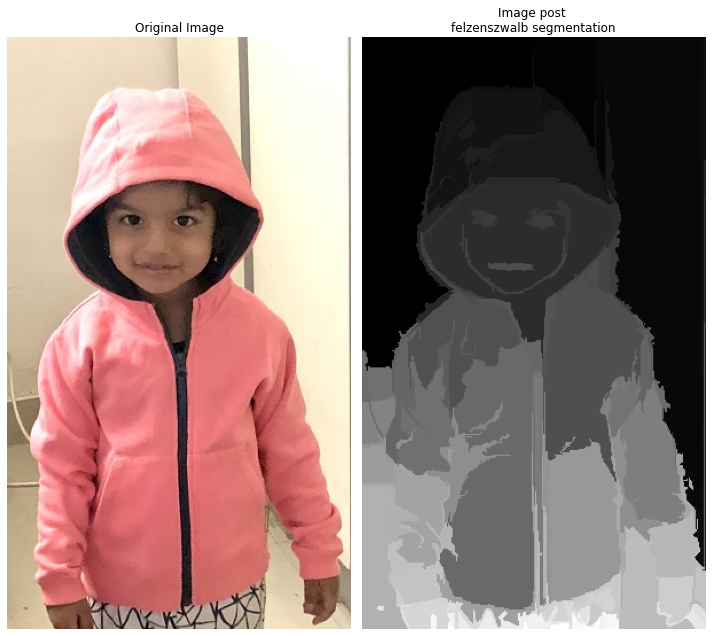

In [6]:
subplots([img, segments_fz], titles=['Original Image','Image post \nfelzenszwalb segmentation'], figsize=(10,10), nc=2)


À partir de la sortie précédente, notez que les pixels qui appartiennent au même groupe ont des valeurs de pixels similaires

Les pixels qui ont des valeurs similaires forment une proposition de région. Cela aide maintenant à la détection d'objets, car nous passons maintenant chaque proposition de région à un réseau et lui demandons de prédire si la proposition de région est un arrière-plan ou un objet. De plus, s'il s'agit d'un objet, cela nous aiderait à identifier le décalage pour récupérer la zone de délimitation stricte correspondant à l'objet et également la classe correspondant au contenu dans la proposition de région

Maintenant que nous comprenons ce que fait SelectiveSearch, implémentons la fonction de recherche sélective pour récupérer les propositions de région pour l'image donnée


## Implementing SelectiveSearch to generateregion proposals.

Dans cette section, nous définirons la fonction extract_candidates à l'aide de la recherche sélective afin qu'elle puisse être exploitée dans les sections suivantes sur la formation des détecteurs d'objets personnalisés basés sur R-CNN et Fast R-CNN.

* **1** Définir la fonction extract_candidates qui récupère les propositions de région à partir d'une image

Récupérez les régions candidates dans l'image à l'aide de la méthode de selective_search disponible dans le package de selectivesearch

In [7]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    # Calculer la zone de l'image et initialiser une liste (candidats) que nous utiliserons pour stocker les candidats qui passent un seuil défini
    img_area = np.prod(img.shape[:2])
    candidates = []

    #Récupérer uniquement les candidats (régions) qui représentent plus de 5 % de la zone totale
    # de l'image et inférieurs ou égaux à 100 % de la zone de l'image et les renvoyer
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

* **2** récupérez une image

In [8]:
img = read('Hemanvi.jpeg', 1)

* **3** Extrayez les candidats et placez-les au-dessus d'une image

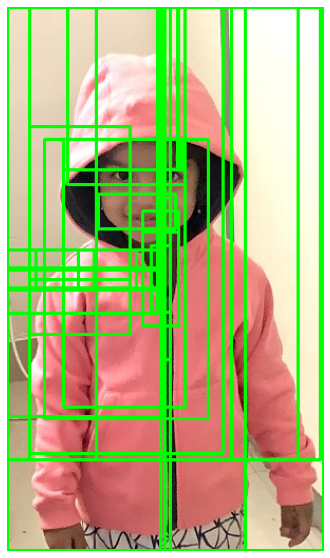

In [9]:

candidates = extract_candidates(img)
show(img, bbs = candidates)

Les grilles du schéma précédent représentent les régions candidates (regionproposals) issues de la méthode select_search.

Maintenant que nous comprenons la génération de propositions de région, une question reste sans réponse. Comment exploiter les propositions de régions pour la détection et la localisation d'objets ?

Une proposition de région qui a une intersection élevée avec l'emplacement (vérité ) d'un objet dans l'image d'intérêt est étiquetée comme celle qui contient l'objet, et une proposition de région avec une intersection basse est étiquetée comme arrière-plan.

Dans la section suivante, nous apprendrons comment calculer l'intersection d'une région candidate avec une boîte englobante de vérité  dans notre voyage pour comprendre les différentes techniques qui forment l'épine dorsale de la construction d'un modèle de détection d'objets.

## Understanding IoU

Imaginez un scénario où nous avons proposé une prédiction d'une boîte englobante pour un objet. Comment mesurons-nous l'exactitude de notre prédiction? Le concept d'Intersection sur Union (IoU) est utile dans un tel scénario.

L'intersection dans le terme Intersection sur Union mesure le chevauchement des cadres de délimitation prévus et réels, tandis que Union mesure l'espace global possible pour le chevauchement. IoU est le rapport de la région de chevauchement entre les deux cadres de délimitation sur la région combinée des deux cadres de délimitation.
Ceci peut être représenté dans un diagramme comme suit:

<img src='https://www.researchgate.net/profile/Ahmet-Bozkir/publication/341253069/figure/fig4/AS:902980098334721@1592298640808/Graphical-illustration-of-intersection-over-union-IoU-metric-fo-rmulation.jpg' width=500px>

Dans le schéma précédent de deux boîtes englobantes (rectangles), considérons la boîte englobante gauche comme la vérité  et la boîte englobante droite comme l'emplacement prévu de l'objet. IoU en tant que métrique est le rapport de la région de chevauchement sur la région combinée entre les deux cadres de délimitation.

Maintenant que nous avons l'intuition de mesurer l'IoU, implémentons-le dans le code et créons une fonction pour calculer l'IoU car nous allons l'exploiter dans les sections de formation R-CNN et de formation Fast R-CNN

In [10]:

def get_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

Nous attendrons la construction d'un modèle jusqu'aux prochaines sections, car la formation d'un modèle est plus impliquée et nous devrons également apprendre quelques composants supplémentaires avant de l'entraîner. Dans la section suivante, nous en apprendrons davantage sur la suppression non maximale, ce qui aide à présélectionner les différentes zones de délimitation prédites possibles autour d'un objet lors de l'inférence à l'aide du modèle entraîné sur une nouvelle image.

## Non-max suppression

Imaginez un scénario dans lequel plusieurs propositions de régions sont générées et se chevauchent de manière significative. Essentiellement, toutes les coordonnées de la boîte englobante prédites (décalages vers les propositions de région) se chevauchent de manière significative. Par exemple, considérons l'image suivante, où plusieurs propositions de région sont générées pour la personne dans l'image.

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2020/07/Screenshot-from-2020-07-27-20-53-06.png' width=500px>

Dans l'image précédente, je vous demande d'identifier la boîte parmi les nombreuses propositions de région que nous considérerons comme celle contenant un objet et les boîtes que nous rejetterons. La suppression non maximale est utile dans un tel scénario. Décompressons le terme "Suppression non max.

Non-max fait référence aux cases qui ne contiennent pas la probabilité la plus élevée de contenir un objet, et la suppression fait référence au rejet des cases qui ne contiennent pas les probabilités les plus élevées de contenir un objet. Dans la suppression non maximale, nous identifions la boîte englobante qui a la probabilité la plus élevée et éliminons toutes les autres boîtes englobantes qui ont une IoU supérieure à un certain seuil avec la boîte contenant la probabilité la plus élevée de contenir un objet.

Dans PyTorch, la suppression non maximale est effectuée à l'aide de la fonction nms du module torchvision.ops. La fonction nms prend les coordonnées de la zone de délimitation, la confiance de l'objet dans la zone de délimitation et le seuil d'IoU à travers les zones de délimitation, pour identifier les zones de délimitation à conserver. 




## Mean average precision

Jusqu'à présent, nous avons cherché à obtenir une sortie qui comprend un cadre de délimitation autour de chaque objet dans l'image et la classe correspondant à l'objet dans le cadre de délimitation. Vient maintenant la question suivante : comment quantifier la précision des prédictions issues de notre modèle ?

mAP vient à la rescousse dans un tel scénario. Avant d'essayer de comprendre la mAP, comprenons d'abord la précision, puis la précision moyenne, et enfin la mAP.

 **Précision** : En règle générale, nous calculons la précision comme:

 $$Precision = \frac{True\ positives}{True\ positives + false\ positives}$$

Un vrai positif fait référence aux cadres de délimitation qui ont prédit la bonne classe d'objets et qui ont une IoU avec la vérité qui est supérieure à un certain seuil. Un faux positif fait référence aux cadres de délimitation qui ont prédit la classe de manière incorrecte ou ont un chevauchement inférieur au seuil défini avec la vérité . De plus, s'il existe plusieurs boîtes englobantes identifiées pour la même boîte englobante de vérité , une seule boîte peut entrer dans un vrai positif, et tout le reste entre dans un faux positif.

**Précision moyenne** : la précision moyenne est la moyenne des valeurs de précision calculées à différents seuils d'IoU

**mAP** : mAP est la moyenne des valeurs de précision calculées à diverses valeurs IoU threshold dans toutes les classes d'objets présents dans l'ensemble de données.

Jusqu'à présent, nous avons appris à préparer un jeu de données d'entraînement pour notre modèle, à effectuer une suppression non maximale sur les prédictions du modèle et à calculer sa précision. Dans les sections suivantes, nous allons apprendre à entraîner un modèle (basé sur R-CNN et basé sur Fast R-CNN) pour détecter des objets dans de nouvelles images.


## Training R-CNN-based custom objectdetectors

R-CNN signifie Region-based Convolutional Neural Network. Region-based au sein de R-CNN signifie les propositions de région. Les propositions de région sont utilisées pour identifier des objets dans une image. Notez que R-CNN aide à identifier à la fois les objets présents dans l'image et l'emplacement des objets dans l'image. Dans les sections suivantes, nous découvrirons les détails de fonctionnement de R-CNN avant de l'entraîner sur notre ensemble de données personnalisé.

### Working details of R-CNN

Faisons-nous une idée de la détection d'objets basée sur R-CNN à un niveau élevé en utilisant le schéma suivant :

<img src='https://makina-corpus.com/blog/metier/images/rcnn' width=700px>

Nous effectuons les étapes suivantes lors de l'utilisation de la technique R-CNN pour la détection d'objets.
* **1** Extraire des propositions de région à partir d'une image :
 * Veiller à extraire un grand nombre de propositions pour ne manquer aucun objet potentiel au sein de l'image

* **2** Redimensionner toutes les régions extraites pour obtenir des images de la même taille

* **3** Passer les propositions de régions redimensionnées à travers un réseau.
 * En règle générale, nous passons les propositions de régions redimensionnées à travers un modèle pré-entraîné tel que VGG16 ou ResNet50 et extrayons les caractéristiques dans une couche entièrement connectée.

* **4** Créer des données pour l'apprentissage du modèle, où l'entrée est constituée de caractéristiques extraites en passant les propositions de région à travers un modèle pré-entraîné, et les sorties sont la classe correspondant à chaque proposition de région et le cardre de la proposition de région par rapport à la vérité  correspondant à l'image
 * Si une proposition de région a une IoU supérieure à un certain seuil avec l'objet, nous préparons les données d'apprentissage de manière à ce que la région soit responsable de prédire la classe d'objet avec laquelle elle chevauche et également le décalage de la proposition de région avec la boîte englobante de vérité terrain qui contient l'objet d'intérêt.

* **5** Connectez deux têtes de sortie, l'une correspondant à la classe d'image et l'autre correspondant au boite de la proposition de région avec la boîte de vérité  pour extraire la boîte de délimitation fine sur l'objet.
  * Cet exercice serait similaire au cas d'utilisation où nous avons prédit le sexe (variable catégorielle, analogue à la classe d'objet dans cette étude de cas) et l'âge (variable continue, analogue aux boites à faire au-dessus des propositions de région) sur la base de l'image de la visage d'une personne dans l'article précédent.

* **6** Entraînez le  modèle, en écrivant une fonction de perte personnalisée qui minimise à la fois l'erreur de classification d'objet et l'erreur de cadre de la zone de délimitation.

Notez que la fonction de perte que nous allons minimiser diffère de la fonction de perte qui est optimisée dans l'article original. Nous faisons cela pour réduire la complexité associée à la création de R-CNN et Fast R-CNN à partir de zéro. Une fois que le lecteur est familiarisé avec le fonctionnement du modèle et peut créer un modèle à l'aide du code suivant, nous l'encourageons fortement à implémenter le document original à partir de zéro.

Dans la section suivante, nous apprendrons à récupérer des ensembles de données et à créer des données pour l'entraînement. Dans la section suivante, nous apprendrons à concevoir le modèle et à l'entraîner avant de prédire la classe d'objets présents et leurs cadres de délimitation dans une nouvelle image


### Implementing R-CNN for object detection on acustom dataset

#### Downloading the dataset

Pour le scénario de détection d'objets, nous allons télécharger les données du jeu de données Google OpenImages v6 (disponible sur https://storage.googleapis. com/openimages/v5/test-annotations-bbox.csv). Cependant, dans le code, nous ne travaillerons que sur les images d'un bus ou d'un camion pour nous assurer que nous pouvons former des images (comme vous le remarquerez bientôt les problèmes de mémoire associés à l'utilisation de la recherche sélective). 

In [11]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from google.colab import files
files.upload() # upload kaggle.json file which you can get 
# by clicking on Create New API token in your personal account
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Saving kaggle.json to kaggle.json
kaggle.json
 98% 361M/367M [00:08<00:00, 39.0MB/s]
100% 367M/367M [00:08<00:00, 46.6MB/s]


In [12]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head())

            ImageID  Source LabelName  ...  XClick2Y  XClick3Y  XClick4Y
0  0000599864fd15b3  xclick       Bus  ...  0.512700  0.650047  0.457197
1  00006bdb1eb5cd74  xclick     Truck  ...  0.241855  0.352130  0.437343
2  00006bdb1eb5cd74  xclick     Truck  ...  0.398496  0.409774  0.295739
3  00010bf498b64bab  xclick       Bus  ...  0.493882  0.705228  0.521691
4  00013f14dd4e168f  xclick       Bus  ...  0.303940  0.999062  0.523452

[5 rows x 21 columns]


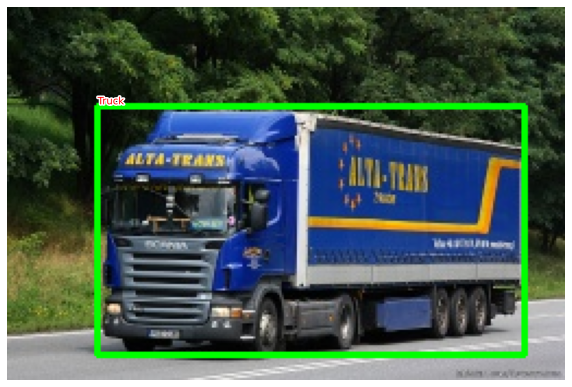

In [13]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df[['XMin', 'YMin', 'XMax', 'YMax']].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
    
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

In [14]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
    
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

Dans cette section, nous allons apprendre à créer les valeurs d'entrée et de sortie correspondant à notre modèle. L'entrée constitue les candidats extraits par la méthode de recherche sélective et la sortie constitue la classe correspondant aux candidats et le cadre du candidat par rapport au cadre de délimitation avec lequel il se chevauche le plus si le candidat contient un objet. Nous continuerons le codage d'où nous nous sommes arrêtés dans la section précédente.

Initialiser des listes vides pour stocker les chemins de fichiers (FPATHS), les cadres de délimitation de la vérité  (GTBBS), les classes (CLSS) d'objets, le décalage delta d'un cadre de délimitation avec les propositions de région (DELTAS), les emplacements de proposition de région (ROIS) et l'IoU de la région propositions avec vérités (IOUS).


Pour cet exercice, nous pouvons utiliser tous les points de données pour l'entraînement ou illustrer avec seulement les 500 premiers points de données. Vous pouvez choisir entre l'un ou l'autre des deux, qui dicte le temps d'entraînement et la précision de l'entraînement (plus les points de données sont grands, plus le temps d'entraînement et la précision sont grands)

Extrayez les candidats de chaque image (im) en valeurs de pixels absolues (notez que XMin, Xmax, YMin et YMax sont disponibles en proportion de la forme des images dans le bloc de données téléchargé) à l'aide de la fonction extract_candidates et convertissez les coordonnées des régions extraites à partir d'un (x, système y,w,h) à un système (x,y,x+w,y+h)

Initialisez ious, rois, deltas et clss en tant que listes qui stockent iou pour chaque candidat, l'emplacement de la proposition de région, le décalage du cadre de délimitation et la classe correspondant à chaque candidat pour chaque image. Nous passerons en revue toutes les propositions de SelectiveSearch et stockerons celles avec un IOU élevé en tant que propositions de bus/camion (quelle que soit la classe dans les étiquettes) et le reste en tant que propositions de fond

Stocker l'IoU de tous les candidats par rapport à toutes les vérités pour une image où bbs est la boîte englobante de la vérité des différents objets présents dans l'image et les candidats sont la proposition de régioncandidats obtenus à l'étape précédente

Extraire l'IoU correspondant au candidat par rapport à toutes les boîtes englobantes de vérité  qui ont déjà été calculées lors de la récupération de la liste des listes d'ious

Trouver l'indice d'un candidat (best_iou_at) qui a l'IoU le plus élevé et la vérité correspondante (best_bb)

Si IoU (best_iou) est supérieur à un seuil (0,3), on attribue le label de classe correspondant au candidat, et le background sinon

Récupérer les décalages nécessaires (delta) pour transformer la proposition actuelle en la candidate qui est la meilleure proposition de région (qui est la boîte englobante de vérité fondamentale) - best_bb, en d'autres termes, combien devraient les marges gauche, droite, supérieure et inférieure du courant la proposition soit ajustée afin qu'elle s'aligne exactement avec best_bb de la vérité terrain

In [15]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)

    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])

    ious, rois, clss, deltas = [], [], [], []

    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

    for jx, candidate in enumerate(candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)

        best_iou = candidate_ious[best_iou_at]

        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
      
    # Ajoutez les chemins de fichier, IoU, roi, classe delta et les limites de vérité terrain
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

# Récupérez les noms de chemin d'image et stockez toutes les informations obtenues, FPATHS, IOUS, ROIS, CLSS, DELTAS et GTBBS, dans une liste de listes :
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

Notez que, jusqu'à présent, les classes sont disponibles sous le nom de la classe. Maintenant, nous allons les convertir en leurs indices correspondants de sorte qu'une classe d'arrière-plan ait un indice de classe de 0, une classe de bus ait un indice de classe de 1 et une classe de camion ait un indice de classe de 2

Attribuer des indices à chaque classe

In [16]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

Jusqu'à présent, nous avons attribué une classe à chaque proposition de région et avons également créé l'autre vérité fondamentale du décalage de la boîte englobante. Dans la section suivante, nous allons récupérer le jeu de données et les chargeurs de données correspondant aux informations obtenues (FPATHS, IOUS, ROIS,CLSS, DELTAS, et GTBBS)

## Creating the training data

Jusqu'à présent, nous avons récupéré des données, des propositions de région sur toutes les images, préparé les vérités fondamentales de la classe d'objets présents dans chaque proposition de région, et le décalage correspondant à chaque proposition de région qui a un chevauchement élevé (IoU) avec l'objet dans l'image correspondante

Dans cette section, nous allons préparer une classe de jeu de données basée sur la vérité terrain des propositions de région obtenues et créer des chargeurs de données à partir de celle-ci. Ensuite, nous normaliserons chaque proposition de région en les redimensionnant à la même forme et en les mettant à l'échelle. Nous allons continuer à coder là où nous nous sommes arrêtés dans la section précédente

In [17]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds
    

In [18]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y, x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
        
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [19]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [20]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
        
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [22]:

def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [23]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [24]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 5.000	val_loss: 1.739	val_loc_loss: 0.486	val_regr_loss: 0.125	val_acc: 0.857	(1238.45s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 2162.78it/s]


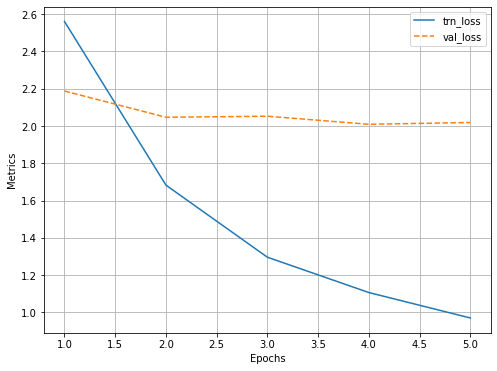

In [25]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

## Predict on a new image

Dans cette section, nous tirerons parti du modèle formé jusqu'à présent pour prédire et dessiner des boîtes englobantes autour des objets et la classe d'objets correspondante dans la boîte englobante prédite sur les nouvelles images. La stratégie que nous adoptons est la suivante:

* **1** Extraire les propositions de région de la nouvelle image
* **2** Redimensionner et normaliser chaque recadrage
* **3** Feed-forward les cultures transformées pour faire des prédictions de classe et les décalages
* **4** Effectuez une suppression non maximale pour récupérer uniquement les boîtes qui ont la plus grande confiance de contenir un objet

Nous exécutons la stratégie précédente via une fonction qui prend une image en entrée et une boîte englobante de vérité  (cela est utilisé uniquement pour comparer la vérité terrain et la boîte englobante prédite). Nous allons continuer à coder là où nous nous sommes arrêtés dans la section précédente

In [26]:
def test_predictions(filename, show_output=True):

    # La fonction prend le nom de fichier comme input

    # Lire l'image et extraire les candidats
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []

    # Parcourez les candidats pour redimensionner et prétraiter l'image
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)

    # Prédire la classe et le décalage
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)

    # Extrayez les candidats qui n'appartiennent pas à la classe d'arrière-plan et additionnez les candidats avec les valeurs de décalage de cadre de délimitation prédites
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    ixs = clss!=background_class

    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)

    # Utilisez des nms de suppression non max pour éliminer les boîtes englobantes presque en double (les paires de boîtes qui ont une IoU supérieure à 0,05 
    #sont considérées comme des doublons dans ce cas). Parmi les cases dupliquées, nous choisissons cette case avec la plus grande confiance et rejetons le reste
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

    #Récupérez le cadre de délimitation avec la plus grande confiance
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x, y, X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

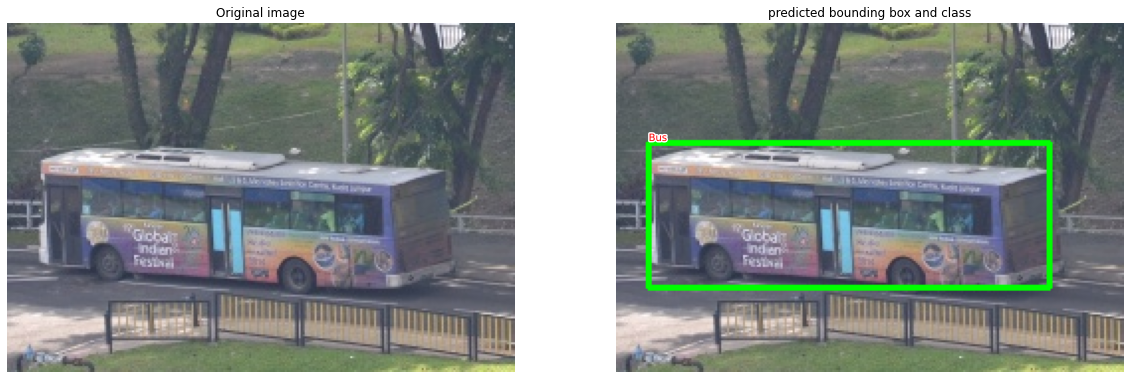

((16, 60, 218, 133), 'Bus', 0.9506451)

In [27]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)

images : À partir du diagramme précédent, nous pouvons voir que la prédiction de la classe d'une image est précise et que la prédiction de la boîte englobante est également correcte. Notez qu'il a fallu environ 1,5 seconde pour générer une prédiction pour l'image précédente.

Tout ce temps est consacré à la génération de propositions de région, au redimensionnement de chaque proposition de région, à leur transmission à travers une dorsale VGG et à la génération de prédictions à l'aide du modèle défini. La plupart du temps, cependant, est consacré à la transmission de chaque proposition via une dorsale VGG. Dans la section suivante, nous apprendrons à contourner ce problème de "passer chaque proposition à VGG" en utilisant le modèle basé sur l'architecture Fast R-CNN.